<a href="https://colab.research.google.com/github/Erenfc/Analysis-of-UGA-Football-Roster-2022/blob/main/FB_Player_BMI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

In [109]:
url = 'https://www.sicemdawgs.com/uga-football-roster'
response_status = requests.get(url)
text = response_status.text

table = BeautifulSoup(text).find('table')

all_trs =  table.tbody.find_all('tr')

all_tds = [tr.find_all('td') for tr in all_trs]

rows = [[td.text for td in row] for row in all_tds]

all_ths = table.thead.find_all('th')

cols = [th.text for th in all_ths]

In [110]:
data = pd.DataFrame(data=rows, columns=cols)
data.columns = ['JerseyNum', 'Name', 'Position', 'Class', 'Height', 'Weight', 'Home']

In [111]:
data['JerseyNum'] = data['JerseyNum'].replace(to_replace='—', value='N/A')

def convert_height(height):
    if isinstance(height, str):
        feet, inches = height.split('-')
        return int(feet) * 12 + int(inches)
    return height

data['Height'] = data['Height'].apply(convert_height)

data['Weight'] = data['Weight'].astype(int)

data['City'] = [i.split(', ')[0] for i in data['Home']]

data['State'] = [i.split(', ')[-1].split(' (')[0] for i in data['Home']]

def extract_high_school(home):
    parts = home.split(' (')
    if len(parts) > 1:
        return parts[1][:-1]
    else:
        return 'N/A'

data['High School'] = [extract_high_school(i) for i in data['Home']]

In [113]:
data.drop(columns=['Home'], inplace=True)

In [86]:
data.groupby('Position')['Name'].count().sort_values(ascending=False).to_dict()

{'WR': 22,
 'DB': 19,
 'OL': 19,
 'DL': 12,
 'ILB': 9,
 'RB': 9,
 'TE': 8,
 'OLB': 7,
 'QB': 5,
 'PK': 4,
 'P': 2,
 'S': 2,
 'SN': 2,
 'C': 1,
 'CB': 1}

In [47]:
data.groupby("Class")["Name"].count().sort_values(ascending=False).to_dict()

{'Fr.': 23, 'Jr.': 23, 'RSo.': 21, 'Sr.': 20, 'RFr.': 18, 'So.': 16, 'GSr.': 1}

In [118]:
data['Weight'].fillna('N/A')

def weight_class(weight):
    if weight >= 270:
        v = 'Heavy'
    elif weight < 270 and weight >= 220:
        v = 'Average'
    elif weight < 220:
        v ='Light'
    else:
        v = 'N/A'
    return v

data['Weight Class'] = data['Weight'].apply(weight_class)

In [119]:
categories = {'Heavy': 0,'Average': 0, 'Light': 0, 'N/A': 0}

for i in data['Weight Class']:
    if i == 'Heavy':
        categories['Heavy'] += 1
    elif i == 'Average':
        categories['Average'] += 1
    elif i == 'Light':
        categories['Light'] += 1
    elif i == 'N/A':
        categories['N/A'] += 1
    else: pass

categories

{'Heavy': 31, 'Average': 32, 'Light': 59, 'N/A': 0}

In [120]:
data['BMI'] = [round((703*w)/data['Height'][index]**2,2) for index, w in enumerate(data['Weight'])]

In [121]:
categories = {'Overweight': 0,
              'Normal': 0,
              'Underweight': 0}

for i in data['BMI']:
    if i >= 25:
        categories['Overweight'] += 1
    elif i >= 18.5:
        categories['Normal'] += 1
    else:
        categories['Underweight'] += 1

categories

{'Overweight': 106, 'Normal': 16, 'Underweight': 0}

In [124]:
data

,JerseyNum,Name,Position,Class,Height,Weight,City,State,High School,Weight Class,BMI
0,0,Troy Bowles,ILB,So.,72,220,Tampa,FL,Jesuit,Average,29.83
1,0,Roderick Robinson II,RB,So.,72,240,San Diego,CA,Lincoln,Average,32.55
2,2,"Smael Mondon, Jr.",ILB,Sr.,75,225,Dallas,GA,Paulding County,Average,28.12
3,3,Andrew Paul,RB,RSo.,71,218,Dallas,TX,Parish Episcopal School,Light,30.40
4,4,Oscar Delp,TE,Jr.,77,245,Cumming,GA,West Forsyth,Average,29.05
...,...,...,...,...,...,...,...,...,...,...,...
117,N/A,Henry Waller,DB,RSo.,71,170,Evans,GA,W.S. of Augusta,Light,23.71
118,N/A,Sacovie White,WR,Fr.,69,180,Cartersville,GA,Cass,Light,26.58
119,N/A,Justin Williams,ILB,Fr.,74,215,Conroe,TX,Oak Ridge,Light,27.60
120,N/A,Colbie Young,WR,Sr.,75,215,Binghamton,NY,Binghamton,Light,26.87


Text(0, 0.5, 'Number of Players')

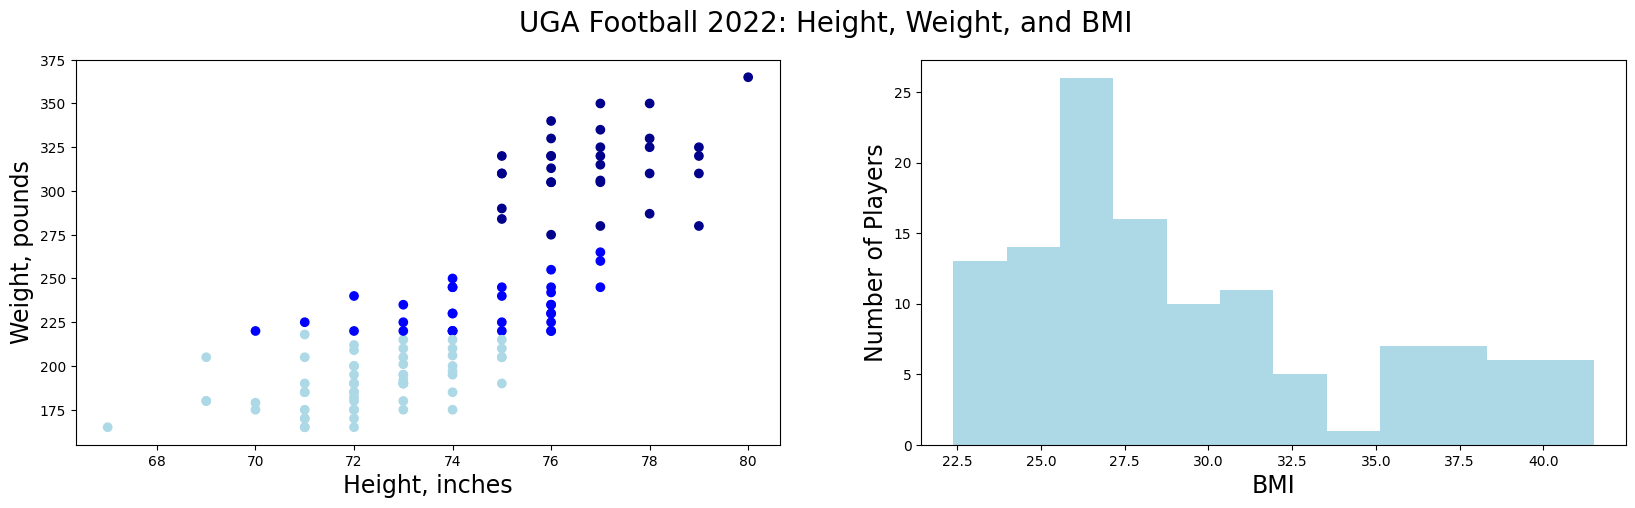

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

colors = {'Heavy': 'darkblue', 'Average': 'blue', 'Light':'lightblue'}

ax[0].scatter(data['Height'], data['Weight'], c=data['Weight Class'].map(colors))
ax[1].hist(data['BMI'], bins = 12, color = 'lightblue')
fig.suptitle('UGA Football 2022: Height, Weight, and BMI', fontsize = 20)

ax[0].set_ylabel('Weight, pounds', fontsize = 17)
ax[0].set_xlabel('Height, inches', fontsize = 17)
ax[1].set_xlabel('BMI', fontsize = 17)
ax[1].set_ylabel('Number of Players', fontsize = 17)